In [20]:
library(Seurat)
library(enrichR)
library(ggplot2)
library(dplyr)
library(stringr)
library(httr)
library(jsonlite)
library(hash)
library(readr)
library(purrr)
library(RColorBrewer)  # For color palettes
library(DESeq2)
library(ggpubr)


In [21]:
data_dir <- '../LCV01_r/outs/'
data <- Load10X_Spatial(data.dir = data_dir, filename = 'filtered_feature_bc_matrix.h5', assay = 'spatial')


data_dir_2 <- '../LVO2-r/outs/'
data_2 <- Load10X_Spatial(data.dir = data_dir, filename = 'filtered_feature_bc_matrix.h5', assay = 'spatial')

data_dir_3 <- '../LVO4-r/outs/'
data_3 <- Load10X_Spatial(data.dir = data_dir, filename = 'filtered_feature_bc_matrix.h5', assay = 'spatial')

In [22]:
snRNA <- readRDS("~/mice_samples/CytoSpace/integrated_lkb1_subset.rds")
snRNA$cellname <- rownames(snRNA@meta.data)
snRNA

An object of class Seurat 
43944 features across 5051 samples within 3 assays 
Active assay: integrated (2000 features, 500 variable features)
 2 other assays present: RNA, SCT
 2 dimensional reductions calculated: pca, umap

In [23]:
snRNA

An object of class Seurat 
43944 features across 5051 samples within 3 assays 
Active assay: integrated (2000 features, 500 variable features)
 2 other assays present: RNA, SCT
 2 dimensional reductions calculated: pca, umap

In [24]:
# For LCV01/LAC12
av_afm_1 <- read.csv("outs/analysis/AvAFM_Barcode.csv")
rownames(av_afm_1) <- av_afm_1$Barcode
indices_1 <- match(rownames(data@meta.data), rownames(av_afm_1))
data@meta.data$AvAFM <- av_afm_1$AvAFM[indices_1]
data_1 <- subset(x = data, subset = AvAFM > 0)




# For LCV02
av_afm_2 <- read.csv("../LCV02/LCV02_outs/analysis/AvAFM_Barcode.csv")
rownames(av_afm_2) <- av_afm_2$Barcode
indices_2 <- match(rownames(data_2@meta.data), rownames(av_afm_2))
data_2@meta.data$AvAFM <- av_afm_2$AvAFM[indices_2]
data_2 <- subset(x = data_2, subset = AvAFM > 0)

# For LCV04
av_afm_3 <- read.csv("../LCV04/LCV04_outs/analysis/AvAFM_Barcode.csv")
rownames(av_afm_3) <- av_afm_3$Barcode
indices_3 <- match(rownames(data_3@meta.data), rownames(av_afm_3))
data_3@meta.data$AvAFM <- av_afm_3$AvAFM[indices_3]
data_3 <- subset(x = data_3, subset = AvAFM > 0)






In [25]:
cyto_results <- read.csv("~/mice_samples/CytoSpace/cell_type_labels/LCV01_cytospace_results/assigned_locations.csv")
cyto_results <- subset(cyto_results, SpotID %in% rownames(data_1@meta.data))
cyto_results <- subset(cyto_results, OriginalCID %in% rownames(snRNA@meta.data))
LCV01_snRNA <- subset(snRNA, cellname %in% cyto_results$OriginalCID)
spot_id_map <- setNames(cyto_results$SpotID, cyto_results$OriginalCID)
LCV01_snRNA$SpotID <- spot_id_map[LCV01_snRNA@meta.data$cellname]
avAFM_map <- setNames(data_1@meta.data$AvAFM, rownames(data_1@meta.data))
LCV01_snRNA$AvAFM <- avAFM_map[LCV01_snRNA@meta.data$SpotID]

cyto_results <- read.csv("~/mice_samples/CytoSpace/cell_type_labels/LCV02_cytospace_results/assigned_locations.csv")
cyto_results <- subset(cyto_results, SpotID %in% rownames(data_2@meta.data))
cyto_results <- subset(cyto_results, OriginalCID %in% rownames(snRNA@meta.data))
LCV02_snRNA <- subset(snRNA, cellname %in% cyto_results$OriginalCID)
spot_id_map <- setNames(cyto_results$SpotID, cyto_results$OriginalCID)
LCV02_snRNA$SpotID <- spot_id_map[LCV02_snRNA@meta.data$cellname]
avAFM_map <- setNames(data_2@meta.data$AvAFM, rownames(data_2@meta.data))
LCV02_snRNA$AvAFM <- avAFM_map[LCV02_snRNA@meta.data$SpotID]



cyto_results <- read.csv("~/mice_samples/CytoSpace/cell_type_labels/LCV04_cytospace_results/assigned_locations.csv")
cyto_results <- subset(cyto_results, SpotID %in% rownames(data_3@meta.data))
cyto_results <- subset(cyto_results, OriginalCID %in% rownames(snRNA@meta.data))
LCV04_snRNA <- subset(snRNA, cellname %in% cyto_results$OriginalCID)
spot_id_map <- setNames(cyto_results$SpotID, cyto_results$OriginalCID)
LCV04_snRNA$SpotID <- spot_id_map[LCV04_snRNA@meta.data$cellname]
avAFM_map <- setNames(data_3@meta.data$AvAFM, rownames(data_3@meta.data))
LCV04_snRNA$AvAFM <- avAFM_map[LCV04_snRNA@meta.data$SpotID]

In [26]:
LCV04_snRNA

An object of class Seurat 
43944 features across 361 samples within 3 assays 
Active assay: integrated (2000 features, 500 variable features)
 2 other assays present: RNA, SCT
 2 dimensional reductions calculated: pca, umap

In [27]:
LCV01_snRNA

An object of class Seurat 
43944 features across 1262 samples within 3 assays 
Active assay: integrated (2000 features, 500 variable features)
 2 other assays present: RNA, SCT
 2 dimensional reductions calculated: pca, umap

In [28]:
LCV02_snRNA

An object of class Seurat 
43944 features across 727 samples within 3 assays 
Active assay: integrated (2000 features, 500 variable features)
 2 other assays present: RNA, SCT
 2 dimensional reductions calculated: pca, umap

In [29]:
processFile = function(filepath) {
  data_frame_signatures <- hash() 
  con = file(filepath, "r")
  while ( TRUE ) {
    line = readLines(con, n = 1)
    if ( length(line) == 0 ) {
      break
    }
    row <- strsplit(line, split = "\t")
    data_frame_signatures[[row[[1]][1]]] <-  row[[1]][3:length(row[[1]])]
  }
  close(con)
  return (data_frame_signatures)

}

convert_human_to_mouse <- function(gene_list, file_path = "HOM_MouseHumanSequence.rpt") {
    output = c()
    
    # Check if the file already exists
    if (!file.exists(file_path)) {
        # Download the mouse-human gene mapping file from the JAX website
        download.file("https://www.informatics.jax.org/downloads/reports/HOM_MouseHumanSequence.rpt", file_path)
    }
    
    # Load the mouse-human gene mapping file
    mouse_human_genes = read.csv(file_path, sep = "\t")
    
    # Loop through each gene in the provided gene list
    for (gene in gene_list) {
        # Get the class key for the human gene
        class_key = (mouse_human_genes %>% filter(Symbol == gene & Common.Organism.Name == "human"))[['DB.Class.Key']]
        
        # If a valid class key is found, get the corresponding mouse genes
        if (!identical(class_key, integer(0))) {
            mouse_genes = (mouse_human_genes %>% filter(DB.Class.Key == class_key & Common.Organism.Name == "mouse, laboratory"))[,"Symbol"]
            
            # Add each mouse gene to the output list
            for (mouse_gene in mouse_genes) {
                output = rbind(c(gene, mouse_gene), output)
            }
        }
    }
    return (output)
}


# Process the hallmark signatures (sig1) to convert to mouse genes
convert_signatures_to_mouse <- function(sig_hallmark) {
    sig_hallmark_mouse <- hash()
    
    for (key in names(sig_hallmark)) {
        human_genes <- sig_hallmark[[key]]
        mouse_genes <- convert_human_to_mouse(human_genes)[,2]  # Take the second column (mouse genes)
        sig_hallmark_mouse[[key]] <- unique(mouse_genes)  # Keep only unique mouse genes
    }
    
    return(sig_hallmark_mouse)
}

# Function to add mechanosensitive and hallmark signatures to a Seurat object
add_signatures <- function(data_obj, sig_mechano, sig_hallmark) {
    # Add mechanosensitive signature
    data_obj <- AddModuleScore(data_obj, 
                               features = list(sig_mechano), 
                               name = "Mechanosensitive_Signature")
    
    # Loop through all hallmark signatures from sig1 and add them
    for (key in names(sig_hallmark)) {
        data_obj <- AddModuleScore(data_obj, 
                                   features = list(sig_hallmark[[key]]), 
                                   name = key)
    }
    
    return(data_obj)
}


mechano_signature <- unique(read.csv("mechanosensative_geneset.csv")$Symbol)
sig1 <- processFile("MSigDB_Hallmark_2020.txt")
sig2 <- processFile("GO_Biological_Process_2023.txt")


# Process the mechanosensitive signature
mechano_signature_mouse <- convert_human_to_mouse(mechano_signature)[,2]  # Get mouse genes (second column)

# Convert the hallmark signatures to mouse genes
sig1_mouse <- convert_signatures_to_mouse(sig1)


Warning message:
“There was 1 warning in `filter()`.
ℹ In argument: `DB.Class.Key == class_key & Common.Organism.Name == "mouse, laboratory"`.
Caused by warning in `DB.Class.Key == class_key`:
! longer object length is not a multiple of shorter object length”
Warning message:
“There was 1 warning in `filter()`.
ℹ In argument: `DB.Class.Key == class_key & Common.Organism.Name == "mouse, laboratory"`.
Caused by warning in `DB.Class.Key == class_key`:
! longer object length is not a multiple of shorter object length”
Warning message:
“There was 1 warning in `filter()`.
ℹ In argument: `DB.Class.Key == class_key & Common.Organism.Name == "mouse, laboratory"`.
Caused by warning in `DB.Class.Key == class_key`:
! longer object length is not a multiple of shorter object length”
Warning message:
“There was 1 warning in `filter()`.
ℹ In argument: `DB.Class.Key == class_key & Common.Organism.Name == "mouse, laboratory"`.
Caused by warning in `DB.Class.Key == class_key`:
! longer object length is n

In [30]:

combined_data <- merge(data_1, y = list(data_2, data_3), 
                       add.cell.ids = c("LCV01", "LCV02", "LCV04"))

combined_data <- add_signatures(combined_data, mechano_signature_mouse, sig1_mouse)

# Add signatures to data_1, data_2, and data_3 (with mouse gene signatures)


Warning message:
“The following features are not present in the object: Cracd, Kcnk2, Mir432, Mir152, Mir378a, Chi3l1, Nos3, Notch4, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: Gpx4, Slc66a3, Atp5po, Mtarc2, Cs, Mrpl15, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: Eif3j2, Wars1, Aars1, H2-Ea, Rps3a1, Dars1, Rps9, Rars1, Ccl19-ps3, Rpl39, Rps19, Mrpl3, Rpl9-ps6, Cd1d2, Rpl3l, Fyb1, not searching for symbol synonyms”
Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Allograft.Rejection1; see ?make.names for more details on syntax validity”
Warning message:
“The following features are not present in the object: Rrp12, Rps6ka3, Ube2i, not searching for symbol synonyms”
Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Androgen.Response1; see ?make.names for more detail

In [31]:
mechano_signature_mouse

[1] "Cib3"      "Unc50"     "Arhgef40"  "Crybg3"    "Cracd"     "Tmc2"     
  [7] "Jcad"      "Syne3"     "Cib2"      "Ulk2"      "Clrn1"     "Arhgap24" 
 [13] "Asic2"     "Gpsm2"     "Rap2a"     "Pdlim5"    "G3bp2"     "Tmc1"     
 [19] "Dmp1"      "Pdlim7"    "Arhgef2"   "Itgb7"     "Myl2"      "Rrm2b"    
 [25] "Pdcd10"    "Slamf1"    "Kcnk2"     "Pkhd1"     "Asic1"     "Yes1"     
 [31] "Wwc1"      "Ppp1r12a"  "Mrtfa"     "Panx1"     "Actn1"     "Sdc4"     
 [37] "Klf2"      "Trpc1"     "Kcnn4"     "Nfatc2"    "Ulk1"      "Tac1"     
 [43] "Cgas"      "Wnt1"      "Tacr1"     "Kcnma1"    "Bag3"      "Lox"      
 [49] "Fscn1"     "Cxcl1"     "Cxcl3"     "Cd47"      "Trem1"     "Pxn"      
 [55] "Gp1ba"     "Pecam1"    "Wwtr1"     "Dnm1l"     "Itga2"     "Sost"     
 [61] "Trpv4"     "Olr1"      "Flna"      "Sele"      "Pak1"      "Itga2b"   
 [67] "Wnt5a"     "Prkaa1"    "Itgb2l"    "Thbs1"     "Mmp14"     "Twist1"   
 [73] "Prkca"     "Mapk8"     "Vhl"       "Rhoa"      "Vwf"       "Itgb3"    
 [79] "Src"       "Cav1"      "Nfe2l2"    "Ptgs2"     "Cdh1"      "Akt1"     
 [85] "Egfr"      "Palmd"     "Itgb1bp2"  "Smpx"      "Gprc5b"    "Mir432"   
 [91] "Ehd2"      "Synm"      "Xylt1"     "Zic1"      "Mapk8ip1"  "Sp7"      
 [97] "Dsc2"      "Bmp1"      "Smarce1"   "Col4a2"    "Angptl2"   "Adora2b"  
[103] "Mir152"    "Cma1"      "Krit1"     "Dsg3"      "Tmsb4x"    "Cav3"     
[109] "Mir378a"   "Mylk"      "Krt14"     "Des"       "Kmt2d"     "Smad1"    
[115] "Dysf"      "Col4a1"    "Krt5"      "Acta2"     "Sfrp1"     "Ctsl"     
[121] "Muc5b"     "Cyp24a1"   "Trpa1"     "Srsf1"     "Map1lc3a"  "Furin"    
[127] "Traf2"     "Ctsb"      "Gfap"      "Muc5ac"    "Itga5"     "Rock1"    
[133] "Pgf"       "Sox9"      "Gnas"      "Nampt"     "Tnfsf11"   "Chi3l1"   
[139] "Runx2"     "Bmp2"      "Fgf2"      "Fn1"       "Col1a1"    "Tnfrsf11b"
[145] "Gja6"      "Gja1"      "Ccn2"      "Edn1"      "Agtr1b"    "Mapk3"    
[151] "Mapk14"    "Notch1"    "Hmgb1"     "Ccnd1"     "Sirt1"     "Mtor"     
[157] "Nos3"      "Tnf"       "Tgfb1"     "Ankrd2"    "Ldb3"      "Mgat5"    
[163] "Pls3"      "Adam15"    "Ctnna1"    "Flnc"      "Notch4"    "Vcl"      
[169] "Bcar1"     "Pkd2"      "Cdh5"      "Trpm7"     "Piezo1"    "Jag1"     
[175] "Pkd1"      "Hspb1"     "Ptk2"      "Lmna"      "Itgb1"     "Yap1"     
[181] "Mapk1"     "Trp53"

In [32]:
combined_data@meta.data$origin <- sapply(strsplit(rownames(combined_data@meta.data), "_"), `[`, 1)
combined_data@meta.data
combined_metadata <- combined_data@meta.data
combined_metadata$group <- ifelse(combined_metadata$origin %in% c("LCV01", "LCV02"), "Soft Samples", "Stiff Samples")


,orig.ident,nCount_spatial,nFeature_spatial,AvAFM,Mechanosensitive_Signature1,Adipogenesis1,Allograft.Rejection1,Androgen.Response1,Angiogenesis1,Apical.Junction1,⋯,Reactive.Oxygen.Species.Pathway1,Spermatogenesis1,TGF.beta.Signaling1,TNF.alpha.Signaling.via.NF.kB1,Unfolded.Protein.Response1,UV.Response.Dn1,UV.Response.Up1,Wnt.beta.Catenin.Signaling1,Xenobiotic.Metabolism1,origin
,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
LCV01_AACACTTGGCAAGGAA-1,SeuratProject,6624,929,1709.4238,0.1442870727,0.437327110,0.1150344082,-0.178312382,-0.09681263,4.485594e-01,⋯,0.62447388,-0.199378385,0.618104766,0.3801502208,0.38026234,-0.056998640,0.581585590,-0.130945453,-0.2744274658,LCV01
LCV01_AACTCAACCTTGACCA-1,SeuratProject,77,60,2173.8909,0.0108008858,0.014482040,-0.0047082563,-0.005759631,-0.00595770,-4.602076e-05,⋯,0.01338532,-0.003325110,0.031618112,-0.0001271099,0.00144134,0.002189645,-0.006930210,-0.005965293,0.0005404092,LCV01
LCV01_AACTGCCTCGATAGGT-1,SeuratProject,2472,675,2284.4224,0.3809212502,0.179163576,-0.0335548684,-0.014298136,-0.12265416,1.670417e-01,⋯,0.25379767,-0.035644374,0.492188103,0.0484470307,0.01389104,-0.046086806,0.224104150,-0.038595841,-0.0993610431,LCV01
LCV01_AACTTCGCTTAGTCAG-1,SeuratProject,66,59,1701.6073,0.0004858783,0.004761195,-0.0042038002,-0.004735697,-0.00655347,1.647046e-02,⋯,-0.00958231,-0.002359755,-0.005835765,0.0006045974,0.01256578,-0.004202942,-0.005661298,-0.006236443,-0.0043966781,LCV01
LCV01_AAGCAGCGGACACGTG-1,SeuratProject,4075,835,1387.7131,0.2009898987,0.470596545,0.0712514916,-0.085949798,-0.24657432,4.085213e-01,⋯,0.49447709,-0.114356799,0.649437266,0.1611113862,0.23640884,-0.059438810,0.407563050,0.079208772,-0.1080050590,LCV01
LCV01_AAGCCAGGCCGACGTG-1,SeuratProject,708,326,2673.3763,0.0837764626,-0.005195370,-0.0037132819,-0.022572741,-0.04200179,6.249868e-02,⋯,-0.01414379,-0.029389681,0.045698053,0.0491296273,0.01410385,-0.011855852,-0.008806105,-0.029026242,-0.0249512113,LCV01
LCV01_AAGGCCGACCTACCTG-1,SeuratProject,5185,877,1343.8781,0.2117897419,0.517613128,0.1008359043,-0.072835256,-0.22520107,2.289906e-01,⋯,0.72449525,-0.133966400,0.878205425,0.1523044860,0.46485645,-0.172434690,0.150706369,0.049355854,-0.2119640098,LCV01
LCV01_AAGTACTGGATGCGCA-1,SeuratProject,6377,921,1270.4974,0.2488176267,0.860851607,0.0726056997,-0.294798123,-0.28798034,4.973227e-01,⋯,1.33301998,-0.227303276,0.401093048,0.5016272543,0.69505495,-0.175343720,0.593621182,-0.001117666,-0.2532287445,LCV01
LCV01_AAGTCTTAAGTTGCCA-1,SeuratProject,1021,416,1829.9571,0.0643965934,0.087638399,0.0006937394,-0.037477849,-0.02882038,4.107415e-02,⋯,0.22301036,-0.025027151,0.013184506,0.0448458586,0.01125987,-0.023475874,0.030088656,-0.011699116,-0.0181781671,LCV01


In [48]:
LCV01_snRNA

An object of class Seurat 
43944 features across 1262 samples within 3 assays 
Active assay: RNA (21851 features, 0 variable features)
 2 other assays present: SCT, integrated
 2 dimensional reductions calculated: pca, umap

In [49]:
DefaultAssay(LCV01_snRNA) <- "RNA"
DefaultAssay(LCV02_snRNA) <- "RNA"
DefaultAssay(LCV04_snRNA) <- "RNA"


#combined_snRNA <- merge(LCV01_snRNA, y = LCV04_snRNA, add.cell.ids = c("LCV01", "LCV04"), merge.data = FALSE)
snRNA_list <- list(LCV01_snRNA, LCV02_snRNA, LCV04_snRNA)

# Step 2: Select integration features
features_snRNA <- SelectIntegrationFeatures(object.list = snRNA_list)

# Step 3: Preprocess each dataset (ScaleData and RunPCA)
snRNA_list <- lapply(X = snRNA_list, FUN = function(x) {
  x <- ScaleData(x, features = features_snRNA, verbose = FALSE)
  x <- RunPCA(x, features = features_snRNA, verbose = FALSE)
  return(x)
})

# Step 4: Find integration anchors using RPCA
snRNA_anchors <- FindIntegrationAnchors(object.list = snRNA_list, reduction = "rpca", dims = 1:30)

# Step 5: Integrate the datasets
combined_snRNA <- IntegrateData(anchorset = snRNA_anchors, dims = 1:30)

# Step 6: Proceed with downstream analysis (optional)
# Example: Run PCA, UMAP, and clustering on the integrated data
combined_snRNA <- ScaleData(combined_snRNA, verbose = FALSE)
combined_snRNA <- RunPCA(combined_snRNA, npcs = 30, verbose = FALSE)
combined_snRNA <- RunUMAP(combined_snRNA, reduction = "pca", dims = 1:30)
combined_snRNA <- FindNeighbors(combined_snRNA, dims = 1:30)
combined_snRNA <- FindClusters(combined_snRNA, resolution = 0.5)



No variable features found for object1 in the object.list. Running FindVariableFeatures ...

No variable features found for object2 in the object.list. Running FindVariableFeatures ...

No variable features found for object3 in the object.list. Running FindVariableFeatures ...

Computing 2000 integration features

No variable features found for object1 in the object.list. Running FindVariableFeatures ...

No variable features found for object2 in the object.list. Running FindVariableFeatures ...

No variable features found for object3 in the object.list. Running FindVariableFeatures ...

Scaling features for provided objects

Computing within dataset neighborhoods

Finding all pairwise anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 677 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 618 anchors

Projecting new data onto SVD

Projecting new data onto S

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2350
Number of edges: 80064

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8819
Number of communities: 10
Elapsed time: 0 seconds


In [50]:
mechano_signature <- unique(read.csv("mechanosensative_geneset.csv")$Symbol)
sig1 <- processFile("MSigDB_Hallmark_2020.txt")
sig2 <- processFile("GO_Biological_Process_2023.txt")


# Process the mechanosensitive signature
mechano_signature_mouse <- convert_human_to_mouse(mechano_signature)[,2]  # Get mouse genes (second column)

# Convert the hallmark signatures to mouse genes
sig1_mouse <- convert_signatures_to_mouse(sig1)


genes <- mechano_signature

# Load Enrichr
setEnrichrSite("Enrichr") # Human genes
websiteLive <- TRUE
dbs <- listEnrichrDbs()
if (is.null(dbs)) websiteLive <- FALSE
if (websiteLive) head(dbs)
dbs <- c("GO_Biological_Process_2023")
if (websiteLive) {
  enriched <- enrichr(genes, dbs)
}
mut_enr <- mutate(enriched[[1]], qscore = -log(Adjusted.P.value, base=10))
mut_enr <- subset(mut_enr, P.value	 < 0.05 & qscore > 5)
h_mut_enr1 <- mut_enr[1:50,]$Term



DefaultAssay(combined_snRNA) <- 'RNA'

for(i in unique(h_mut_enr1)) {
    
        if (!is.null(sig2[[i]])){
            combined_snRNA <- AddModuleScore(combined_snRNA,
                          features = list(convert_human_to_mouse(sig2[[i]])[,2]),
                          name=i)
        }
}

combined_snRNA <- add_signatures(combined_snRNA, mechano_signature_mouse, sig1_mouse)

DefaultAssay(combined_snRNA) <- 'integrated'


Warning message:
“There was 1 warning in `filter()`.
ℹ In argument: `DB.Class.Key == class_key & Common.Organism.Name == "mouse, laboratory"`.
Caused by warning in `DB.Class.Key == class_key`:
! longer object length is not a multiple of shorter object length”
Warning message:
“There was 1 warning in `filter()`.
ℹ In argument: `DB.Class.Key == class_key & Common.Organism.Name == "mouse, laboratory"`.
Caused by warning in `DB.Class.Key == class_key`:
! longer object length is not a multiple of shorter object length”
Warning message:
“There was 1 warning in `filter()`.
ℹ In argument: `DB.Class.Key == class_key & Common.Organism.Name == "mouse, laboratory"`.
Caused by warning in `DB.Class.Key == class_key`:
! longer object length is not a multiple of shorter object length”
Warning message:
“There was 1 warning in `filter()`.
ℹ In argument: `DB.Class.Key == class_key & Common.Organism.Name == "mouse, laboratory"`.
Caused by warning in `DB.Class.Key == class_key`:
! longer object length is n

,geneCoverage,genesPerTerm,libraryName,link,numTerms,appyter,categoryId
,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>
1,13362,275,Genome_Browser_PWMs,http://hgdownload.cse.ucsc.edu/goldenPath/hg18/database/,615,ea115789fcbf12797fd692cec6df0ab4dbc79c6a,1
2,27884,1284,TRANSFAC_and_JASPAR_PWMs,http://jaspar.genereg.net/html/DOWNLOAD/,326,7d42eb43a64a4e3b20d721fc7148f685b53b6b30,1
3,6002,77,Transcription_Factor_PPIs,,290,849f222220618e2599d925b6b51868cf1dab3763,1
4,47172,1370,ChEA_2013,http://amp.pharm.mssm.edu/lib/cheadownload.jsp,353,7ebe772afb55b63b41b79dd8d06ea0fdd9fa2630,7
5,47107,509,Drug_Perturbations_from_GEO_2014,http://www.ncbi.nlm.nih.gov/geo/,701,ad270a6876534b7cb063e004289dcd4d3164f342,7
6,21493,3713,ENCODE_TF_ChIP-seq_2014,http://genome.ucsc.edu/ENCODE/downloads.html,498,497787ebc418d308045efb63b8586f10c526af51,7


Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2023... Done.
Parsing results... Done.


Warning message:
“There was 1 warning in `filter()`.
ℹ In argument: `DB.Class.Key == class_key & Common.Organism.Name == "mouse, laboratory"`.
Caused by warning in `DB.Class.Key == class_key`:
! longer object length is not a multiple of shorter object length”
Warning message:
“There was 1 warning in `filter()`.
ℹ In argument: `DB.Class.Key == class_key & Common.Organism.Name == "mouse, laboratory"`.
Caused by warning in `DB.Class.Key == class_key`:
! longer object length is not a multiple of shorter object length”
Warning message:
“There was 1 warning in `filter()`.
ℹ In argument: `DB.Class.Key == class_key & Common.Organism.Name == "mouse, laboratory"`.
Caused by warning in `DB.Class.Key == class_key`:
! longer object length is not a multiple of shorter object length”
Warning message:
“There was 1 warning in `filter()`.
ℹ In argument: `DB.Class.Key == class_key & Common.Organism.Name == "mouse, laboratory"`.
Caused by warning in `DB.Class.Key == class_key`:
! longer object length is n

In [51]:

malig_only <- subset(combined_snRNA, subset = celltypes_minor_v1 == "Malignant" )

malig_only <- FindVariableFeatures(malig_only)
malig_only <- RunPCA(malig_only)
malig_only <- FindNeighbors(malig_only, dims = 1:10)
malig_only <- FindClusters(malig_only, resolution = 0.5)
malig_only <- RunUMAP(malig_only, dims = 1:10)

Warning message in FindVariableFeatures.Assay(object = assay.data, selection.method = selection.method, :
“selection.method set to 'vst' but count slot is empty; will use data slot instead”
Warning message in eval(predvars, data, env):
“NaNs produced”
Warning message in hvf.info$variance.expected[not.const] <- 10^fit$fitted:
“number of items to replace is not a multiple of replacement length”
PC_ 1 
Positive:  Lingo2, Cdh6, Hmgcll1, 4930467D21Rik, Oxr1, Samd12, Wincr1, Epha4, Cadm1, Rims2 
	   Ank3, Ctnnd2, Grip1, Ghr, Klf12, Arap2, Fam189a1, Nr3c2, Efna5, Hmga2 
	   Itga2, Kcnq5, Myo5b, Ap1s3, Pak1, Shroom4, Pdgfd, C1galt1, Adgrl3, Ltbp1 
Negative:  Rftn1, Plcl1, Lrmda, Gphn, Arhgap24, Ptprm, Ebf1, Elmo1, Camk1d, Arhgap31 
	   Trps1, Col1a2, Slc8a1, Col5a2, Abca1, Fbxl7, Dlc1, Mitf, Col1a1, Kalrn 
	   March3, Fli1, Ptprc, Rora, Cacna1c, Col12a1, Dock10, Col3a1, Spon1, Adam19 
PC_ 2 
Positive:  Fam189a1, Dock8, Hmga2, Mir100hg, Plxna4, Frmd4a, Col18a1, Erc2, Dusp5, Ccbe1 
	   Pcdh7, Mi

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1665
Number of edges: 53549

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8161
Number of communities: 6
Elapsed time: 0 seconds


00:01:48 UMAP embedding parameters a = 0.9922 b = 1.112

00:01:48 Read 1665 rows and found 10 numeric columns

00:01:48 Using Annoy for neighbor search, n_neighbors = 30

00:01:48 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

00:01:48 Writing NN index file to temp file /tmp/RtmpBmnovO/file11d447083a7b

00:01:48 Searching Annoy index using 1 thread, search_k = 3000

00:01:49 Annoy recall = 100%

00:01:50 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

00:01:53 Initializing from normalized Laplacian + noise (using irlba)

00:01:53 Commencing optimization for 500 epochs, with 64632 positive edges

00:01:56 Optimization finished



In [52]:
myeloid_cells <- subset(combined_snRNA, subset = celltypes_minor_v1 == "Myeloid")
myeloid_cells <- RunPCA(myeloid_cells)
myeloid_cells <- FindNeighbors(myeloid_cells, dims = 1:10)
myeloid_cells <- FindClusters(myeloid_cells, resolution = 0.5)
myeloid_cells <- RunUMAP(myeloid_cells, dims = 1:10)

Warning message in PrepDR(object = object, features = features, verbose = verbose):
“The following 1 features requested have zero variance (running reduction without them): Npy5r”
PC_ 1 
Positive:  Ptprc, Lrmda, Lair1, Tgfbi, March1, Slc8a1, Nlrp1b, Mertk, Msr1, Myo1f 
	   Sirpa, Cacna1d, Gm26740, Fyb, Tbxas1, Lilrb4a, Camk1d, Aoah, Ccr5, Mitf 
	   Dock10, Arhgap15, Tfec, Trps1, Ctss, Fcgr2b, Mrc1, Lilr4b, Zeb2, Sirpb1b 
Negative:  Cdh13, Aplp2, Ghr, Rbms3, Egfr, Mllt3, Hmga2, Ank3, Lamc2, Glis3 
	   Epha4, Grip1, Klf12, Adam12, mt-Co1, Prickle1, Samd12, Arap2, Creb3l2, Lingo2 
	   Shroom4, C1galt1, Itga2, Cdh6, Ptprg, Dock9, Acsl3, Errfi1, Igf1r, Kcnq5 
PC_ 2 
Positive:  Mrc1, Adgre1, Itga9, Slc9a9, Ms4a7, C1qb, Frmd4b, Ms4a4a, Mertk, Slc16a7 
	   Dab2, Apobec1, Lgmn, Pdgfc, Msr1, F13a1, Rnf150, Abcg3, Gm4951, Tbxas1 
	   Ly86, Cacna1d, Pde7b, Man1c1, C1qa, Aoah, Zdhhc14, Nlrp1b, Bank1, Rassf2 
Negative:  Cd274, Htr7, Gpr141, Mmp12, Il1b, Atp8b4, Dpp4, Fgr, Pdcd1lg2, Acsl1 
	   Tbc1d8

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 233
Number of edges: 8037

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.6408
Number of communities: 4
Elapsed time: 0 seconds


00:02:03 UMAP embedding parameters a = 0.9922 b = 1.112

00:02:03 Read 233 rows and found 10 numeric columns

00:02:03 Using Annoy for neighbor search, n_neighbors = 30

00:02:03 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

00:02:03 Writing NN index file to temp file /tmp/RtmpBmnovO/file11d41ded7746

00:02:03 Searching Annoy index using 1 thread, search_k = 3000

00:02:03 Annoy recall = 100%

00:02:05 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

00:02:07 Initializing from normalized Laplacian + noise (using irlba)

00:02:07 Commencing optimization for 500 epochs, with 8856 positive edges

00:02:09 Optimization finished



In [60]:
DefaultAssay(malig_only) <- "RNA"

# Extract avAFM data and convert it into a vector
lcv_data <- as.vector(unlist(malig_only@meta.data$AvAFM))

# Calculate quartiles and create a factor variable 'm_cell_half' for each sample separately
quartile_breaks <- malig_only@meta.data %>%
    group_by(orig.ident) %>%
    mutate(m_cell_half = cut(AvAFM,
                             breaks = quantile(AvAFM, probs = c(0, 0.50, 1), na.rm = TRUE),
                             include.lowest = TRUE,
                             labels = c("Low AFM", "High AFM")))

# Add the quartile-based grouping back to metadata
malig_only@meta.data$m_cell_half <- unlist(quartile_breaks$m_cell_half)

# Prepare DESeqDataSet with the design including both orig.ident and m_cell_half
dds <- DESeqDataSetFromMatrix(countData = malig_only@assays$RNA@counts,
                              colData = malig_only@meta.data,
                              design = ~ orig.ident + m_cell_half)

# Filter out low counts
keep <- rowSums(counts(dds) >= 3) >=3
dds <- dds[keep,]

# Estimate size factors and run DESeq
dds <- estimateSizeFactors(dds, type='poscounts')
dds <- DESeq(dds)

# Get results including log fold change and p-values
results_data <- as.data.frame(results(dds, contrast = c("m_cell_half", "High AFM", "Low AFM")))

# Prepare data for plotting
results_data$gene <- rownames(results_data)
results_data$logp <- -log10(results_data$pvalue)


GOI <- subset(results_data, log2FoldChange > 0)
GOI <- subset(GOI, pvalue < 0.05)
genes_f <- GOI$gene

combined_snRNA <- AddModuleScore(combined_snRNA,
                          features = list(genes_f),
                          name="malig_signature_quart_pos_half_samp")

GOI <- subset(results_data, log2FoldChange < 0)
GOI <- subset(GOI, pvalue < 0.05)
genes_r <- GOI$gene

combined_snRNA <- AddModuleScore(combined_snRNA,
                          features = list(genes_r),
                          name="malig_signature_quart_neg_quart_half_samp")



converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x

In [61]:
max_length <- max(length(genes_f), length(genes_r), length(mechano_signature))

genes_f <- c(genes_f, rep(NA, max_length - length(genes_f)))
genes_r <- c(genes_r, rep(NA, max_length - length(genes_r)))
mechano_signature <- c(mechano_signature, rep(NA, max_length - length(mechano_signature)))

# Combine into a data frame
data_table <- data.frame(
  genes_f,
  genes_r,
  mechano_signature
)

# Save to CSV
write.csv(data_table, "Supplemental_Table2.csv", row.names = FALSE)


In [59]:
GOI <- subset(results_data, log2FoldChange > 0)
GOI <- subset(GOI, pvalue < 0.05)
genes_f <- GOI$gene

malig_only <- AddModuleScore(malig_only,
                          features = list(genes_f),
                          name="malig_signature_quart_pos")

GOI <- subset(results_data, log2FoldChange < 0)
GOI <- subset(GOI, pvalue < 0.05)
genes_r <- GOI$gene

malig_only <- AddModuleScore(malig_only,
                          features = list(genes_r),
                          name="malig_signature_quart_neg")


In [ ]:
malig_only@meta.data

In [88]:
malig_only <- subset(combined_snRNA, subset = celltypes_minor_v1 == "Malignant" )

DefaultAssay(malig_only) <- 'integrated'

malig_only <- FindVariableFeatures(malig_only)
malig_only <- RunPCA(malig_only)
malig_only <- FindNeighbors(malig_only, dims = 1:10)
malig_only <- FindClusters(malig_only, resolution = 0.5)
malig_only <- RunUMAP(malig_only, dims = 1:10)

Warning message in FindVariableFeatures.Assay(object = assay.data, selection.method = selection.method, :
“selection.method set to 'vst' but count slot is empty; will use data slot instead”
Warning message in eval(predvars, data, env):
“NaNs produced”
Warning message in hvf.info$variance.expected[not.const] <- 10^fit$fitted:
“number of items to replace is not a multiple of replacement length”
PC_ 1 
Positive:  Lingo2, Cdh6, Hmgcll1, 4930467D21Rik, Oxr1, Samd12, Wincr1, Epha4, Cadm1, Rims2 
	   Ank3, Ctnnd2, Grip1, Ghr, Klf12, Arap2, Fam189a1, Nr3c2, Efna5, Hmga2 
	   Itga2, Kcnq5, Myo5b, Ap1s3, Pak1, Shroom4, Pdgfd, C1galt1, Adgrl3, Ltbp1 
Negative:  Rftn1, Plcl1, Lrmda, Gphn, Arhgap24, Ptprm, Ebf1, Elmo1, Camk1d, Arhgap31 
	   Trps1, Col1a2, Slc8a1, Col5a2, Abca1, Fbxl7, Dlc1, Mitf, Col1a1, Kalrn 
	   March3, Fli1, Ptprc, Rora, Cacna1c, Col12a1, Dock10, Col3a1, Spon1, Adam19 
PC_ 2 
Positive:  Fam189a1, Dock8, Hmga2, Mir100hg, Plxna4, Frmd4a, Col18a1, Erc2, Dusp5, Ccbe1 
	   Pcdh7, Mi

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1665
Number of edges: 53549

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8161
Number of communities: 6
Elapsed time: 0 seconds


20:25:41 UMAP embedding parameters a = 0.9922 b = 1.112

20:25:41 Read 1665 rows and found 10 numeric columns

20:25:41 Using Annoy for neighbor search, n_neighbors = 30

20:25:41 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

20:25:42 Writing NN index file to temp file /tmp/RtmpCWihLW/file9d17fd592d2

20:25:42 Searching Annoy index using 1 thread, search_k = 3000

20:25:42 Annoy recall = 100%

20:25:44 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

20:25:46 Initializing from normalized Laplacian + noise (using irlba)

20:25:46 Commencing optimization for 500 epochs, with 64632 positive edges

20:25:49 Optimization finished



In [89]:
write.csv(combined_snRNA@meta.data, "integrated_scRNA_data/all_data_signatures.csv")

write.csv(malig_only@meta.data, "integrated_scRNA_data/malignant_signatures.csv")

In [44]:
saveRDS(malig_only,"integrated_scRNA_data/malignant_tumor.rds")
saveRDS(combined_snRNA,"integrated_scRNA_data/all_tumor.rds")
saveRDS(myeloid_cells,"integrated_scRNA_data/myeloid.rds")


In [31]:
combined_snRNA

An object of class Seurat 
43944 features across 2350 samples within 3 assays 
Active assay: RNA (21851 features, 0 variable features)
 2 other assays present: SCT, integrated
 2 dimensional reductions calculated: pca, umap

,X,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,percent.rps,percent.rpl,percent.rp,predicted_doublets,doublet_scores,⋯,Xenobiotic.Metabolism1,quartile,malig_signature_quart_pos1,malig_signature_quart_neg1,postive_afm_correlate_signature1,negative_afm_correlate_signature1,malig_signature_quart_pos_half1,malig_signature_quart_neg_half1,malig_signature_quart_pos_half_samp1,malig_signature_quart_neg_quart_half_samp1
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<lgl>,<dbl>,⋯,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,LAC12_GGACAGACAAGCGAGT-1,LAC12,24534,5024,0,0,0,0,FALSE,0.03059897,⋯,-0.009202711,4,0.06162821,-0.15920830,-0.4476536,-0.404042614,0.084199678,0.4145572,0.1226646,-0.08945949
2,LAC12_CGGACACAGTTGTCGT-1,LAC12,23513,5308,0,0,0,0,FALSE,0.11524910,⋯,-0.015962180,2,0.12124926,-0.04854248,-0.4183379,0.499591939,0.043414773,0.4040066,0.2755259,-0.07910611
3,LAC12_AGTCTTTGTAGGGTAC-1,LAC12,23235,5119,0,0,0,0,FALSE,0.10756860,⋯,-0.025285076,3,-0.03773054,0.01920663,-0.4604475,-0.005294301,0.080096457,0.3499584,0.2416409,-0.04577278
4,LAC12_CAGCATAGTCTCGTTC-1,LAC12,22469,4945,0,0,0,0,FALSE,0.05482173,⋯,0.005181315,4,-0.17916271,-0.15031281,-0.4579871,0.712243912,-0.005276322,0.5315491,0.1176505,-0.10554104
5,LAC12_GAACCTATCCGAACGC-1,LAC12,22095,4958,0,0,0,0,FALSE,0.04755802,⋯,-0.026364085,1,0.08099150,0.08846487,-0.4443585,0.031366595,0.027291612,0.5952395,0.3219232,-0.07200615
6,LAC12_GGGTCTGCATCCTTGC-1,LAC12,21772,4563,0,0,0,0,FALSE,0.03193486,⋯,-0.001443052,3,0.01786868,-0.05582513,-0.4348451,-0.085756624,-0.004593960,0.3422740,0.1511578,-0.17718697


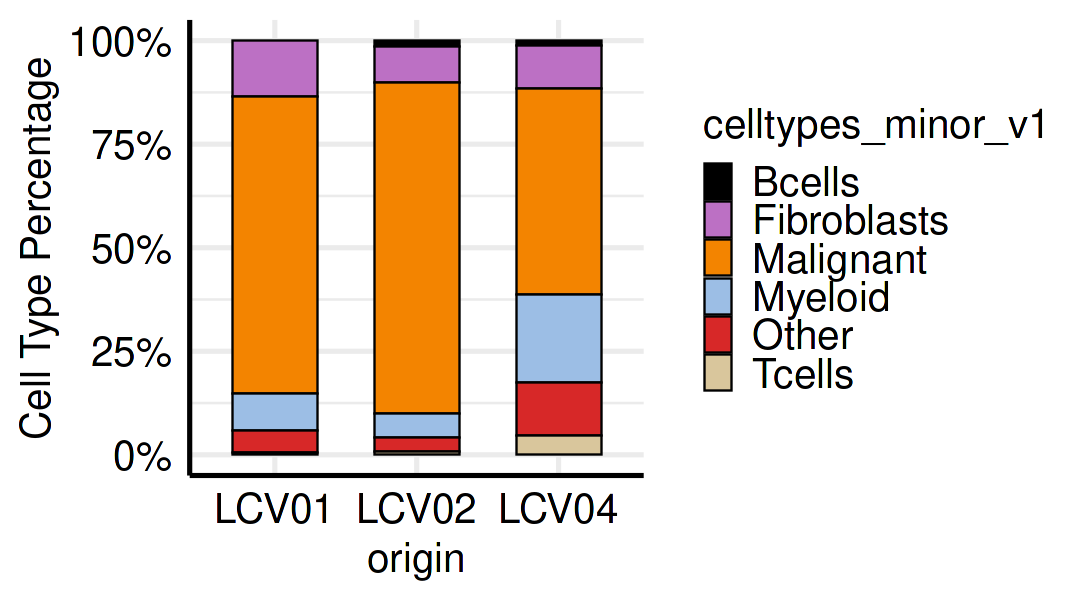

In [29]:


# Initialize an empty data frame to store combined metadata
combined_metadata <- read.csv('integrated_scRNA_data/all_data_signatures.csv')


# Check the first few rows of the combined metadata
head(combined_metadata)
cell_counts <- combined_metadata %>%
  group_by(orig.ident, celltypes_minor_v1) %>%
  summarise(Count = n(), .groups = 'drop')

# View the structure to confirm it's correct
total_counts <- cell_counts %>%
  group_by(orig.ident) %>%
  summarise(Total = sum(Count))

# Join the counts back to the original data to calculate percentages
percentage_data <- cell_counts %>%
  left_join(total_counts, by = "orig.ident") %>%
  mutate(Percentage = Count / Total) %>%
  select(orig.ident, celltypes_minor_v1, Percentage)

percentage_data <- percentage_data %>%
  mutate(orig.ident = recode(orig.ident, "LAC12" = "LCV01", "LAC5" = "LCV02", "LAC6" = "LCV04"))

# Set the order based on the new labels
percentage_data <- percentage_data %>%
  mutate(orig.ident = factor(orig.ident, levels = c("LCV01", "LCV02", "LCV04")))

#'Malignant''Endothelial''Fibroblasts''Myeloid''Other''Tcells''Bcells'
# Combine "Endothelial" cells into "Other" in the percentage_data
percentage_data <- percentage_data %>%
  mutate(celltypes_minor_v1 = ifelse(celltypes_minor_v1 == "Endothelial", "Other", celltypes_minor_v1)) %>%
  group_by(orig.ident, celltypes_minor_v1) %>%
  summarise(Percentage = sum(Percentage), .groups = 'drop')


cell_types_with_colors <- c("Malignant", "Tcells", "Bcells", "Myeloid", "Fibroblasts", "Other")
colors <- c("#f6766e", "#b79f00", "#35bb38", "#3ebfc4", "#f664e3", "#619cff")

cell_types_with_colors <- c("Bcells", "Endothelial", "Fibroblasts", "Malignant", "Myeloid", "Other", "Tcells")
colors <- c("#000000", "#f3c300", "#bc70c4", "#f38400", "#9cbee5", "#d72828", "#d9c69c")


celltype_colors <- setNames(colors, cell_types_with_colors)

options(repr.plot.width=9, repr.plot.height=5)

ggplot(percentage_data, aes(x = orig.ident, y = Percentage, fill = celltypes_minor_v1)) +
  geom_bar(stat = "identity", position = "fill", width = 0.6, color = "black") +  # Adjust bar width and add black border
  scale_y_continuous(labels = scales::percent_format()) +  # Format y-axis labels as percentages
  scale_fill_manual(values = celltype_colors) +  # Use the custom colors
  theme_minimal(base_size = 24) +  # Set the base font size to 24
  labs(x = "origin", y = "Cell Type Percentage") +
  theme(
    #axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1, size = 24, color = "black"),  # Adjust x-axis text angle and size
          axis.text.x = element_text( size = 24, color = "black"),  # Adjust x-axis text angle and size

    axis.text.y = element_text(size = 24, color = "black"),  # Adjust y-axis text size
    axis.title.x = element_text(size = 24, color = "black"),  # Adjust x-axis title size
    axis.title.y = element_text(size = 24, color = "black"),  # Adjust y-axis title size
    plot.title = element_text(size = 24, face = "bold"),  # Adjust title size and make bold
    legend.text = element_text(size = 24, color = "black"),  # Adjust legend text size
    legend.title = element_text(size = 24, color = "black"),  # Adjust legend title size
    axis.line = element_line(color = "black")  # Make both x and y axis lines black
  )





In [34]:
unique(combined_metadata$celltypes_minor_v1)

[1] "Malignant"   "Endothelial" "Fibroblasts" "Myeloid"     "Other"      
[6] "Tcells"      "Bcells"